# LSTM 

- To overcome RNN's problem, which is 'Long term Dependency
 > Long term dependency 
    - 현재 state와 과거 input과의 term이 길 때, input을 반영하지 못하는 현상 
        (이전 state에서 현재로 오면서 곱하는게 큰 원인)
        
#### LSTM Cell's structure 
  - Cell state와 hidden layer가 별도로 존재 
  - Cell state는 정보의 기억을 주로 담당
  - Forget gate는 Cell 상에서 크게 중요하지 않은 정보를 삭제 
  - Hidden layer(tanh) 는 input gate(sigmoid)를 통해 중요한 정보만을 Cell에 update
  - Cell state는 forget gate, input gate를 거친 후 다음 State로 넘어간다. 
  - hidden layer는 다음 Cell에서 다음 step의 input 과 Concatnate(it makes memorize longer)하여 Cell에 입력 
<img src="./static/LSTM.png" > <img/>
  
#### GRU cell's structure
  - input gate를 1-forget gate로 처리하면서 weight 개수를 줄여 연산량을 줄임
  - 실제로 input gate와 forget gate는 반대로 가는 경향이 있음 
  - LSTM과 비슷한 성능을 내며, 연산량은 감소 
<img src="./static/GRU.png" > <img/>
  
$*$ **Dynamic RNN** 
 - static RNN보다 더 많이 사용한다. 
 - Padding에 대하여 loss를 구하지 않게 하여, 가변 길이 데이터를 더 원할하게 학습 할 수있다. 
 > loss를 구할 때, Gate 처럼 먼저 length를 같이 받아서 넣어주면, padding 부분의 loss는 구하지 않는다. 
 
###### Bidirectional RNN 
- RNN Cell을 두개씩 가지고 서로 반대 방향의 time step별 state를 가지는 RNN구조 
- 양방향의 loss를 연결 시킨 것을 낮추려고 노력하면서 더 좋은 성능을 내는 경우가 많다. 

### Learning by implementation 

In [3]:
import tensorflow as tf
import numpy as np 
import matplotlib.pyplot as plt 
%matplotlib inline

epoch : 0,  loss : 0.4771, accuracy : (nan, 0.90146303)
epoch : 10,  loss : 0.0310, accuracy : (0.89132553, 0.89789504)
epoch : 20,  loss : 0.0162, accuracy : (0.9359792, 0.93830913)
epoch : 30,  loss : 0.0093, accuracy : (0.953903, 0.9551259)
epoch : 40,  loss : 0.0068, accuracy : (0.9635361, 0.96426994)
epoch : 50,  loss : 0.0063, accuracy : (0.96957225, 0.9700481)
epoch : 60,  loss : 0.0057, accuracy : (0.96566814, 0.9740252)
epoch : 70,  loss : 0.0052, accuracy : (0.9766884, 0.976946)
epoch : 80,  loss : 0.0049, accuracy : (0.97898906, 0.97918975)
epoch : 90,  loss : 0.0046, accuracy : (0.9808124, 0.9809742)


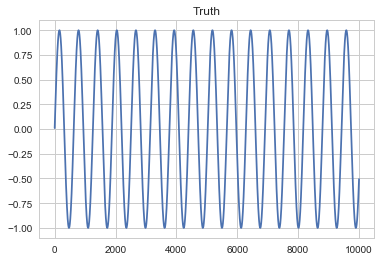

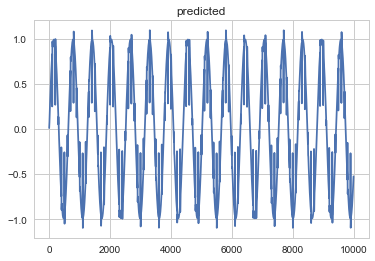

In [2]:
tf.reset_default_graph()
# preparing Data
t = np.array([float(i)*0.01 for i in range(10000+1)])
sin = np.sin(t[:-1])
sin_next = np.sin(t[1:])

time_step = 100 
reshaped_sin = np.reshape(sin, [-1, time_step, 1])
reshaped_sin_next = np.reshape(sin_next, [-1, 1])

signal = tf.placeholder(tf.float32, [None, time_step, 1])
signal_next = tf.placeholder(tf.float32, [None, 1])

inputs = tf.unstack(signal, axis=1)

state_size = 24
rnn_cell = tf.nn.rnn_cell.LSTMCell(state_size)
#rnn_cell = tf.nn.rnn_cell.GRUCell(state_size)
states, state = tf.nn.static_rnn(rnn_cell, inputs, dtype=tf.float32)

reshaped_states = tf.reshape(tf.stack(states, axis=1), [-1, state_size])

out = tf.layers.dense(reshaped_states, 1, use_bias=False)

loss = tf.losses.mean_squared_error(signal_next, out)
train_op = tf.train.AdamOptimizer(1e-2).minimize(loss)
accuracy = tf.contrib.metrics.streaming_pearson_correlation(out, signal_next)

with tf.Session() as sess :
    sess.run(tf.global_variables_initializer())
    sess.run(tf.local_variables_initializer())
    for epoch in range(100):
        _, _loss, _acc = sess.run([train_op, loss, accuracy], feed_dict={
            signal : reshaped_sin, signal_next : reshaped_sin_next})
        if epoch % 10 ==0:
            print(f"epoch : {epoch},  loss : {_loss:.4f}, accuracy : {_acc}")
            
    _pred = sess.run(out, feed_dict={signal : reshaped_sin})
    plt.figure(1)
    plt.title("Truth")
    plt.plot(sin_next)
    plt.figure(2)
    plt.title("predicted")
    plt.plot(_pred)
        

In [4]:
# Bi_Directional LSTM (dynamic)
# dynamic 할때는 unstack, stack이 필요없다.
tf.reset_default_graph()
# preparing Data
t = np.array([float(i)*0.01 for i in range(10000+1)])
sin = np.sin(t[:-1])
sin_next = np.sin(t[1:])

signal = tf.placeholder(tf.float32, [None, 1])
signal_next = tf.placeholder(tf.float32, [None, 1])

state_size = 24

frnn_cell = tf.nn.rnn_cell.BasicLSTMCell(state_size)
brnn_cell = tf.nn.rnn_cell.GRUCell(state_size)

(fstates, bstates), (fstate, bstate) = tf.nn.bidirectional_dynamic_rnn(frnn_cell, brnn_cell, signal, dtype=tf.float32)

freshaped_states = tf.reshape(fstates, [-1, state_size])
breshaped_states = tf.reshape(bstates, [-1, state_size])

foutput = tf.layers.dense(freshaped_states, 1, use_bias=False)
boutput = tf.layers.dense(breshaped_states, 1, use_bias=False)

# loss 를 각각 평균내서 타임스텝마다 고쳐주라 
floss = tf.losses.mean_squared_error(signal_next, foutput)
bloss = tf.losses.mean_squared_error(signal, boutput)
loss = (floss + bloss) / 2 

train_op = tf.train.AdamOptimizer(1e-2).minimize(loss)

accuracy = tf.contrib.metrics.streaming_pearson_correlation(foutput, signal_next)

ValueError: Shape (1, ?) must have rank at least 3